In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error, explained_variance_score, r2_score
import matplotlib.pyplot as plt


In [2]:
# Define dataset paths
train_dir = r'D:\AI Algorithm\Castor\train'
val_dir = r'D:\AI Algorithm\Castor\val'
test_dir = r'D:\AI Algorithm\Castor\test'

# Create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=1, class_mode='binary', shuffle=False)


Found 2070 images belonging to 2 classes.
Found 594 images belonging to 2 classes.
Found 299 images belonging to 2 classes.


In [3]:
# Load InceptionV3 base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [4]:
import os
from PIL import Image

def validate_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify if the image is valid
            except Exception as e:
                print(f"Invalid image: {file_path} - {e}")
                os.remove(file_path)  # Optionally delete invalid files

validate_images(train_dir)
validate_images(val_dir)
validate_images(test_dir)


C:\Users\Anurag\cnn_env\lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
C:\Users\Anurag\cnn_env\lib\site-packages\PIL\JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


In [5]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)


C:\Users\Anurag\cnn_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - accuracy: 0.8314 - loss: 0.3435 - val_accuracy: 0.9226 - val_loss: 0.1685
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - accuracy: 0.9521 - loss: 0.1244 - val_accuracy: 0.9495 - val_loss: 0.1046
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 231s 4s/step - accuracy: 0.9690 - loss: 0.0792 - val_accuracy: 0.9613 - val_loss: 0.0853
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.9889 - loss: 0.0440 - val_accuracy: 0.9596 - val_loss: 0.0953
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 396s 6s/step - accuracy: 0.9817 - loss: 0.0452 - val_accuracy: 0.9562 - val_loss: 0.1065
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 394s 6s/step - accuracy: 0.9798 - loss: 0.0485 - val_accuracy: 0.9630 - val_loss: 0.0815
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.9915 - loss: 0.0297 - val_accuracy: 0.9529 - val_loss: 0.1101
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.9871 - loss: 0.0359 - val_accuracy: 0.9613 - v

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, mean_absolute_error, mean_squared_error, explained_variance_score, r2_score


In [7]:
# Get true labels and predictions from the test generator
y_true = test_generator.classes  # Ground truth labels

# Predict probabilities and classes
y_pred_probs = model.predict(test_generator, verbose=1)  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Predicted classes (0 or 1)

# Reshape arrays if needed
y_pred_probs = y_pred_probs.flatten()
y_true = y_true.flatten()

# Calculate metrics
accuracy = (y_true == y_pred).mean()
precision = precision_score(y_true, y_pred, pos_label=1)
recall = recall_score(y_true, y_pred, pos_label=1)
f1 = f1_score(y_true, y_pred, pos_label=1)
auc = roc_auc_score(y_true, y_pred_probs)
conf_matrix = confusion_matrix(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
mape = 100 * np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-10)))
smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-10))
explained_var = explained_variance_score(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mbd = np.mean(y_pred - y_true)

# Print metrics in the desired format
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")
print("Confusion Matrix:")
print(f" {conf_matrix}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.2f}%")
print(f"Explained Variance Score: {explained_var:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Mean Bias Deviation (MBD): {mbd:.2f}")


299/299 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step
Accuracy: 0.95
Precision: 0.98
Recall: 0.95
F1-Score: 0.96
AUC: 0.99
Confusion Matrix:
 [[ 79   5]
 [ 11 204]]
Mean Absolute Error (MAE): 0.05
Mean Squared Error (MSE): 0.05
Root Mean Squared Error (RMSE): 0.23
Mean Absolute Percentage Error (MAPE): 16722408030.43%
Symmetric Mean Absolute Percentage Error (SMAPE): 10.70%
Explained Variance Score: 0.74
R^2 Score: 0.74
Mean Bias Deviation (MBD): -0.02


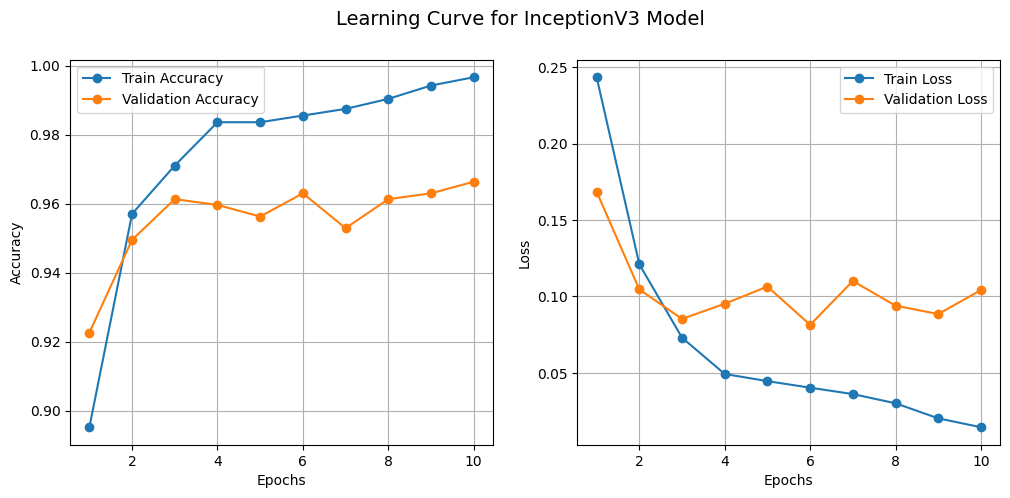

In [9]:
import matplotlib.pyplot as plt

# Ensure history_fine exists before using it
if 'history_fine' in globals():
    train_acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    train_loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']
else:
    print("Warning: history_fine is not defined. Using only history.")
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Learning Curve for InceptionV3 Model', fontsize=14)

# Plot accuracy vs. epochs
axes[0].plot(epochs, train_acc, label='Train Accuracy', marker='o')
axes[0].plot(epochs, val_acc, label='Validation Accuracy', marker='o')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# Plot loss vs. epochs
axes[1].plot(epochs, train_loss, label='Train Loss', marker='o')
axes[1].plot(epochs, val_loss, label='Validation Loss', marker='o')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

plt.show()


In [11]:
import pandas as pd
import os

# Extract accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Generate epoch numbers (X-coordinates)
epochs = list(range(1, len(train_acc) + 1))

# Create a DataFrame
df = pd.DataFrame({
    'Epoch': epochs,
    'Train_Accuracy': train_acc,
    'Validation_Accuracy': val_acc
})

# Define the folder path
folder_path = r"D:\AI Algorithm\Castor\Data"
csv_filename = os.path.join(folder_path, "accuracy_data.csv")

# Save to CSV file
df.to_csv(csv_filename, index=False)

print(f"Accuracy data saved to {csv_filename}")


Accuracy data saved to D:\AI Algorithm\Castor\Data\accuracy_data.csv
